In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern
from sklearn.model_selection import train_test_split
import sklearn.decomposition as skd
from sklearn.model_selection import cross_val_score

In [128]:
def get_raw_data(path):
    _filename = path + '/2D_FZ_FORMATTED.txt'
    _data = pickle.load(open(_filename, 'rb'))
    return _data

def create_dataset(_rawDataPath,_parameterPath):    
    _parameters = []
    # read parameters
    with open(_parameterPath) as _f:
        _csvFile = csv.reader(_f)
        next(_csvFile) # skip column names
        for _r in _csvFile:
            if _r[12] == 'Y': # case has been run
                _parameters.append([float(_i) for _i in _r[0:11]])    
    _X = []
    _Y = []

    for _param in enumerate(_parameters):
        _i = int(_param[1][0])
        _path = f'{_rawDataPath}/RUN_{_i}'
        _x,_y,_ = get_raw_data(_path)
        _X.append(_param[1][:])
        _Y.append(_y[2000:4000])
    return np.array(_X), np.array(_Y)

def normData(x):
    _mean = np.mean(x,axis=0)
    _std = np.std(x,axis=0)
    return (x-_mean)/_std, _mean, _std

def RMSE(x,y):
    return np.sqrt(np.mean((x-y)**2))

def nonDimensionalizeF(X):
    _M = X[:,0]+X[:,1]
    _param = _M**2/np.abs(X[:,2])**3/np.sqrt(1-X[:,0]**2)

    # # _param = 1 to turn off non-dimmensionalization
    # _param = np.ones(_param.shape[0])
    return _param.reshape(-1,1)

def plot_compare(x,y,startN,caseN,param):    
    f=plt.figure(figsize=(40,caseN+5))
    for _n in range (startN, startN+caseN):
        ax=plt.subplot(int(caseN/5),5,_n+1-startN)
        plt.plot(x[_n],'--k',linewidth=0.5,label='Exact')
        for _m in range(len(y)):
            plt.plot(y[_m][_n],label='GPR{}'.format(_m+1))
        plt.title('Case {0:1.0f}, Mleft={1:1.1f}, Mright={2:1.1f}, dz={3:1.1f}'.format(_n,param[_n][0],param[_n][1],param[_n][2]))
        plt.legend(loc=0)
        #plt.ylim([-5000,2000])
    plt.show()

def rel_error(x,y):
    return np.sum(np.linalg.norm(x-y,axis=1)/np.linalg.norm(y,axis=1))

def nrmse_error(pred,orig):
    _max = np.amax(orig,axis = 1)
    _min = np.amin(orig, axis = 1)
    _rng = (_max - _min)

    _rmse = np.sum(np.square(orig-pred), axis = 1) / orig.shape[1]
    _rmse = np.sqrt(_rmse)
    _nrmse = _rmse/_rng
    return np.mean(_nrmse)

In [125]:
folds = pickle.load(open("./2D_CFD_Dataset/gpr_old/folds.pckl","rb"))
# Create dataset and normalize
rawDataPath = "./2D_CFD_Dataset/simulation_files_v2"
parameterPath = "./2D_CFD_Dataset/case_parameters_original.csv"
Xtemp, Ytemp = create_dataset(rawDataPath,parameterPath)
# Select a few cases from the dataset
X = []
Y = []
for n in range(len(Xtemp)):
    if Xtemp[n][0] in folds[0]['train'] or Xtemp[n][0] in folds[0]['test']:
        X.append(Xtemp[n][3:6])
        Y.append(Ytemp[n])
X = np.array(X)
Y = np.array(Y)

# # Create dataset and normalize
# rawDataPath = "./2D_CFD_Dataset/simulation_files_v2"
# parameterPath = "./2D_CFD_Dataset/case_parameters_original.csv"
# Xtemp, Ytemp = create_dataset(rawDataPath,parameterPath)
# # Select a few cases from the dataset
# X = []
# Y = []
# for n in range(Xtemp.shape[0]):
#     #if abs(Xtemp[n][4]) != 3. and Xtemp[n][0] != 5. and Xtemp[n][2] != 0.1 and Xtemp[n][3] != 0.1 and Xtemp[n][2] != 0.8 and Xtemp[n][3] != 0.8:
#     if abs(Xtemp[n][4]) != 3. and Xtemp[n][0] != 5.: # eliminating cases where separation distance = 3 or AOA = 5
#         X.append(Xtemp[n][2:5]) # only AOA = 0 so eliminate the first two columns
#         Y.append(Ytemp[n])
# X = np.array(X)
# Y = np.array(Y)

# Dataset size
print (X.shape, Y.shape)

(122, 3) (122, 2000)


In [126]:
# Split dataset to training set and testing set
n_features = Y.shape[1]
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.2)
# Non-dimentionalize Y to achieve similar output magnitude among cases
NDTrain = nonDimensionalizeF(xTrain)
NDTest = nonDimensionalizeF(xTest)
yTrainND = yTrain/NDTrain
# Normalize dataset using mean&std
xTrainN, xTrainM, xTrainStd = normData(xTrain)
xTestN = (xTest - xTrainM) / xTrainStd
yTrainN, yTrainM, yTrainStd = normData(yTrainND)
# PCA SKLearn
y = yTrainND - np.mean(yTrainND, axis=0) # Zero Mean
pca = skd.PCA(n_components=0.99)
dyn_pca = pca.fit_transform(y)
yTrainN, yTrainM, yTrainStd = normData(dyn_pca)
print("POD reduced output dimension to ",yTrainN.shape[1])

POD reduced output dimension to  4


In [127]:
nRestarts = 5
# Latest version of GPR, no trend function
#kernel = ConstantKernel(1.0, (1e-1,1e1)) * RBF(length_scale=np.ones(X.shape[1]), length_scale_bounds=(1e-2,1e2))
kernel = ConstantKernel(1.0, (1e-1,1e1)) * Matern(length_scale=np.ones(X.shape[1]), length_scale_bounds=(1e-2,1e2), nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=nRestarts).fit(xTrainN,yTrainN)
# Cross validation
scores1 = cross_val_score(gp,xTrainN,yTrainN,cv=9)
print ('GP-1 Cross validation mean score = {0:1.4f}, std = {1:1.4f}'.format(scores1.mean(),scores1.std()))

# Older version of GPR where trend function is still available
import oldVerGPR 
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
gp2 = oldVerGPR.sklGPR(theta = [0.1, 1e-6, 10.0],regr = 'linear', corr = 'matern52',noiseLvl = 1e-14) # TODO: need to compare different trend functions and 
gp2.fit(xTrainN, yTrainN)
# Cross validation
# scores2 = cross_val_score(gp2,xTrainN,yTrainN,cv=9)
# print ('GP-2 Cross validation mean score = {0:1.4f}, std = {1:1.4f}'.format(scores2.mean(),scores2.std()))

GP-1 Cross validation mean score = 0.9198, std = 0.0376

skl: Training GPR


In [129]:
yPredictTraining1 = gp.predict(xTrainN) * yTrainStd + yTrainM
yPredictTesting1 = gp.predict(xTestN) * yTrainStd + yTrainM
yPredictTraining2 = gp2.predict(xTrainN,eval_MSE=False, use_lib=True) * yTrainStd + yTrainM
yPredictTesting2 = gp2.predict(xTestN,eval_MSE=False, use_lib=True) * yTrainStd + yTrainM
# If trained using PCA data
yPredictTraining1 = pca.inverse_transform(yPredictTraining1) + np.mean(yTrainND,axis=0)
yPredictTesting1 = pca.inverse_transform(yPredictTesting1) + np.mean(yTrainND,axis=0)
yPredictTraining2 = pca.inverse_transform(yPredictTraining2) + np.mean(yTrainND,axis=0)
yPredictTesting2 = pca.inverse_transform(yPredictTesting2) + np.mean(yTrainND,axis=0)

# Revert the Non-dimensionalization of forces
yPredictTraining1 = yPredictTraining1 * NDTrain
yPredictTesting1 = yPredictTesting1 * NDTest
yPredictTraining2 = yPredictTraining2 * NDTrain
yPredictTesting2 = yPredictTesting2 * NDTest

# Relative error
print ('GP-1 Training Relative error = {0:2.5f}'.format(rel_error(yPredictTraining1,yTrain)), 'Testing Relative error = {0:2.5f}'.format(rel_error(yPredictTesting1,yTest)))
print ('GP-2 Training Relative error = {0:2.5f}'.format(rel_error(yPredictTraining2,yTrain)),'Testing Relative error = {0:2.5f}'.format(rel_error(yPredictTesting2,yTest)))

print ('GP-1 Training N-RMSE = {0:2.5f}'.format(nrmse_error(yPredictTraining1,yTrain)), 'Testing N-RMSE = {0:2.5f}'.format(nrmse_error(yPredictTesting1,yTest)))
print ('GP-2 Training N-RMSE = {0:2.5f}'.format(nrmse_error(yPredictTraining2,yTrain)),'Testing N-RMSE = {0:2.5f}'.format(nrmse_error(yPredictTesting2,yTest)))

GP-1 Training Relative error = 13.99140 Testing Relative error = 6.19547
GP-2 Training Relative error = 13.99140 Testing Relative error = 6.22534
GP-1 Training N-RMSE = 0.02611 Testing N-RMSE = 0.04715
GP-2 Training N-RMSE = 0.02611 Testing N-RMSE = 0.04735


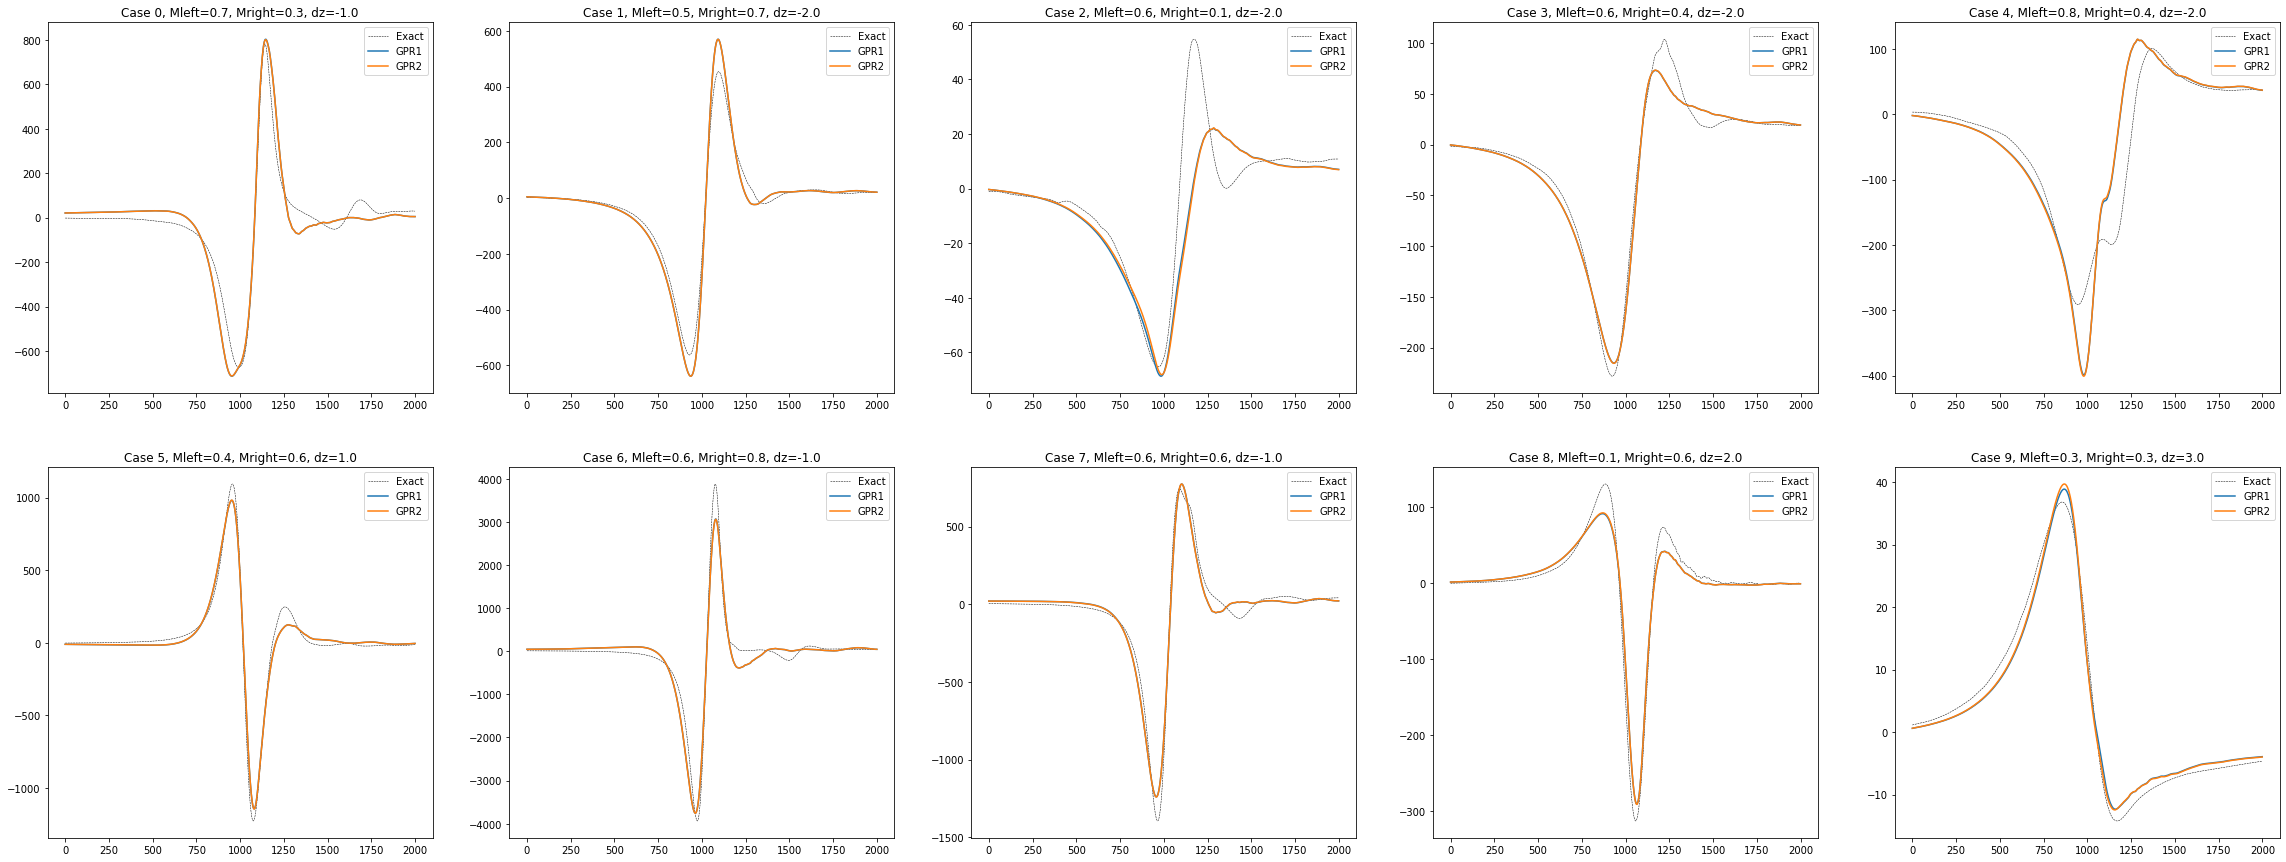

In [130]:
# Plot and compare
#plot_compare(yTrain,[yPredictTraining1,yPredictTraining2],0,20,xTrain)
plot_compare(yTest,[yPredictTesting1,yPredictTesting2],0,10,xTest)

In [131]:
# Prediction using newly generated samples using LDS method
rawDataPath = "./2D_CFD_Dataset/simulation_files_v2"
parameterPath = "./2D_CFD_Dataset/case_parameters_latin.csv"
XX, YY = create_dataset(rawDataPath,parameterPath)
XX = XX[:,3:6]
xxTestN = (XX - xTrainM) / xTrainStd
# Non-dimensionalize output
NDTest2 = nonDimensionalizeF(XX)
# Predict using trained model
yyPredictTesting1 = gp.predict(xxTestN) * yTrainStd + yTrainM
yyPredictTesting2 = gp2.predict(xxTestN) * yTrainStd + yTrainM
yyPredictTesting1 = pca.inverse_transform(yyPredictTesting1) + np.mean(yTrainND,axis=0)
yyPredictTesting2 = pca.inverse_transform(yyPredictTesting2) + np.mean(yTrainND,axis=0)
# Revert the non-dimensionalization
yyPredictTesting1 = yyPredictTesting1 * NDTest2
yyPredictTesting2 = yyPredictTesting2 * NDTest2 
# Relative Error
print ('GP-1 Testing Relative error = {0:2.5f}'.format(rel_error(yyPredictTesting1,YY)))
print ('GP-2 Testing Relative error = {0:2.5f}'.format(rel_error(yyPredictTesting2,YY)))
print ('GP-1 Testing N-RMSE = {0:2.5f}'.format(nrmse_error(yPredictTesting1,yTest)))
print ('GP-2 Testing N-RMSE = {0:2.5f}'.format(nrmse_error(yPredictTesting2,yTest)))

GP-1 Testing Relative error = 3.35368
GP-2 Testing Relative error = 3.29424
GP-1 Testing N-RMSE = 0.04715
GP-2 Testing N-RMSE = 0.04735


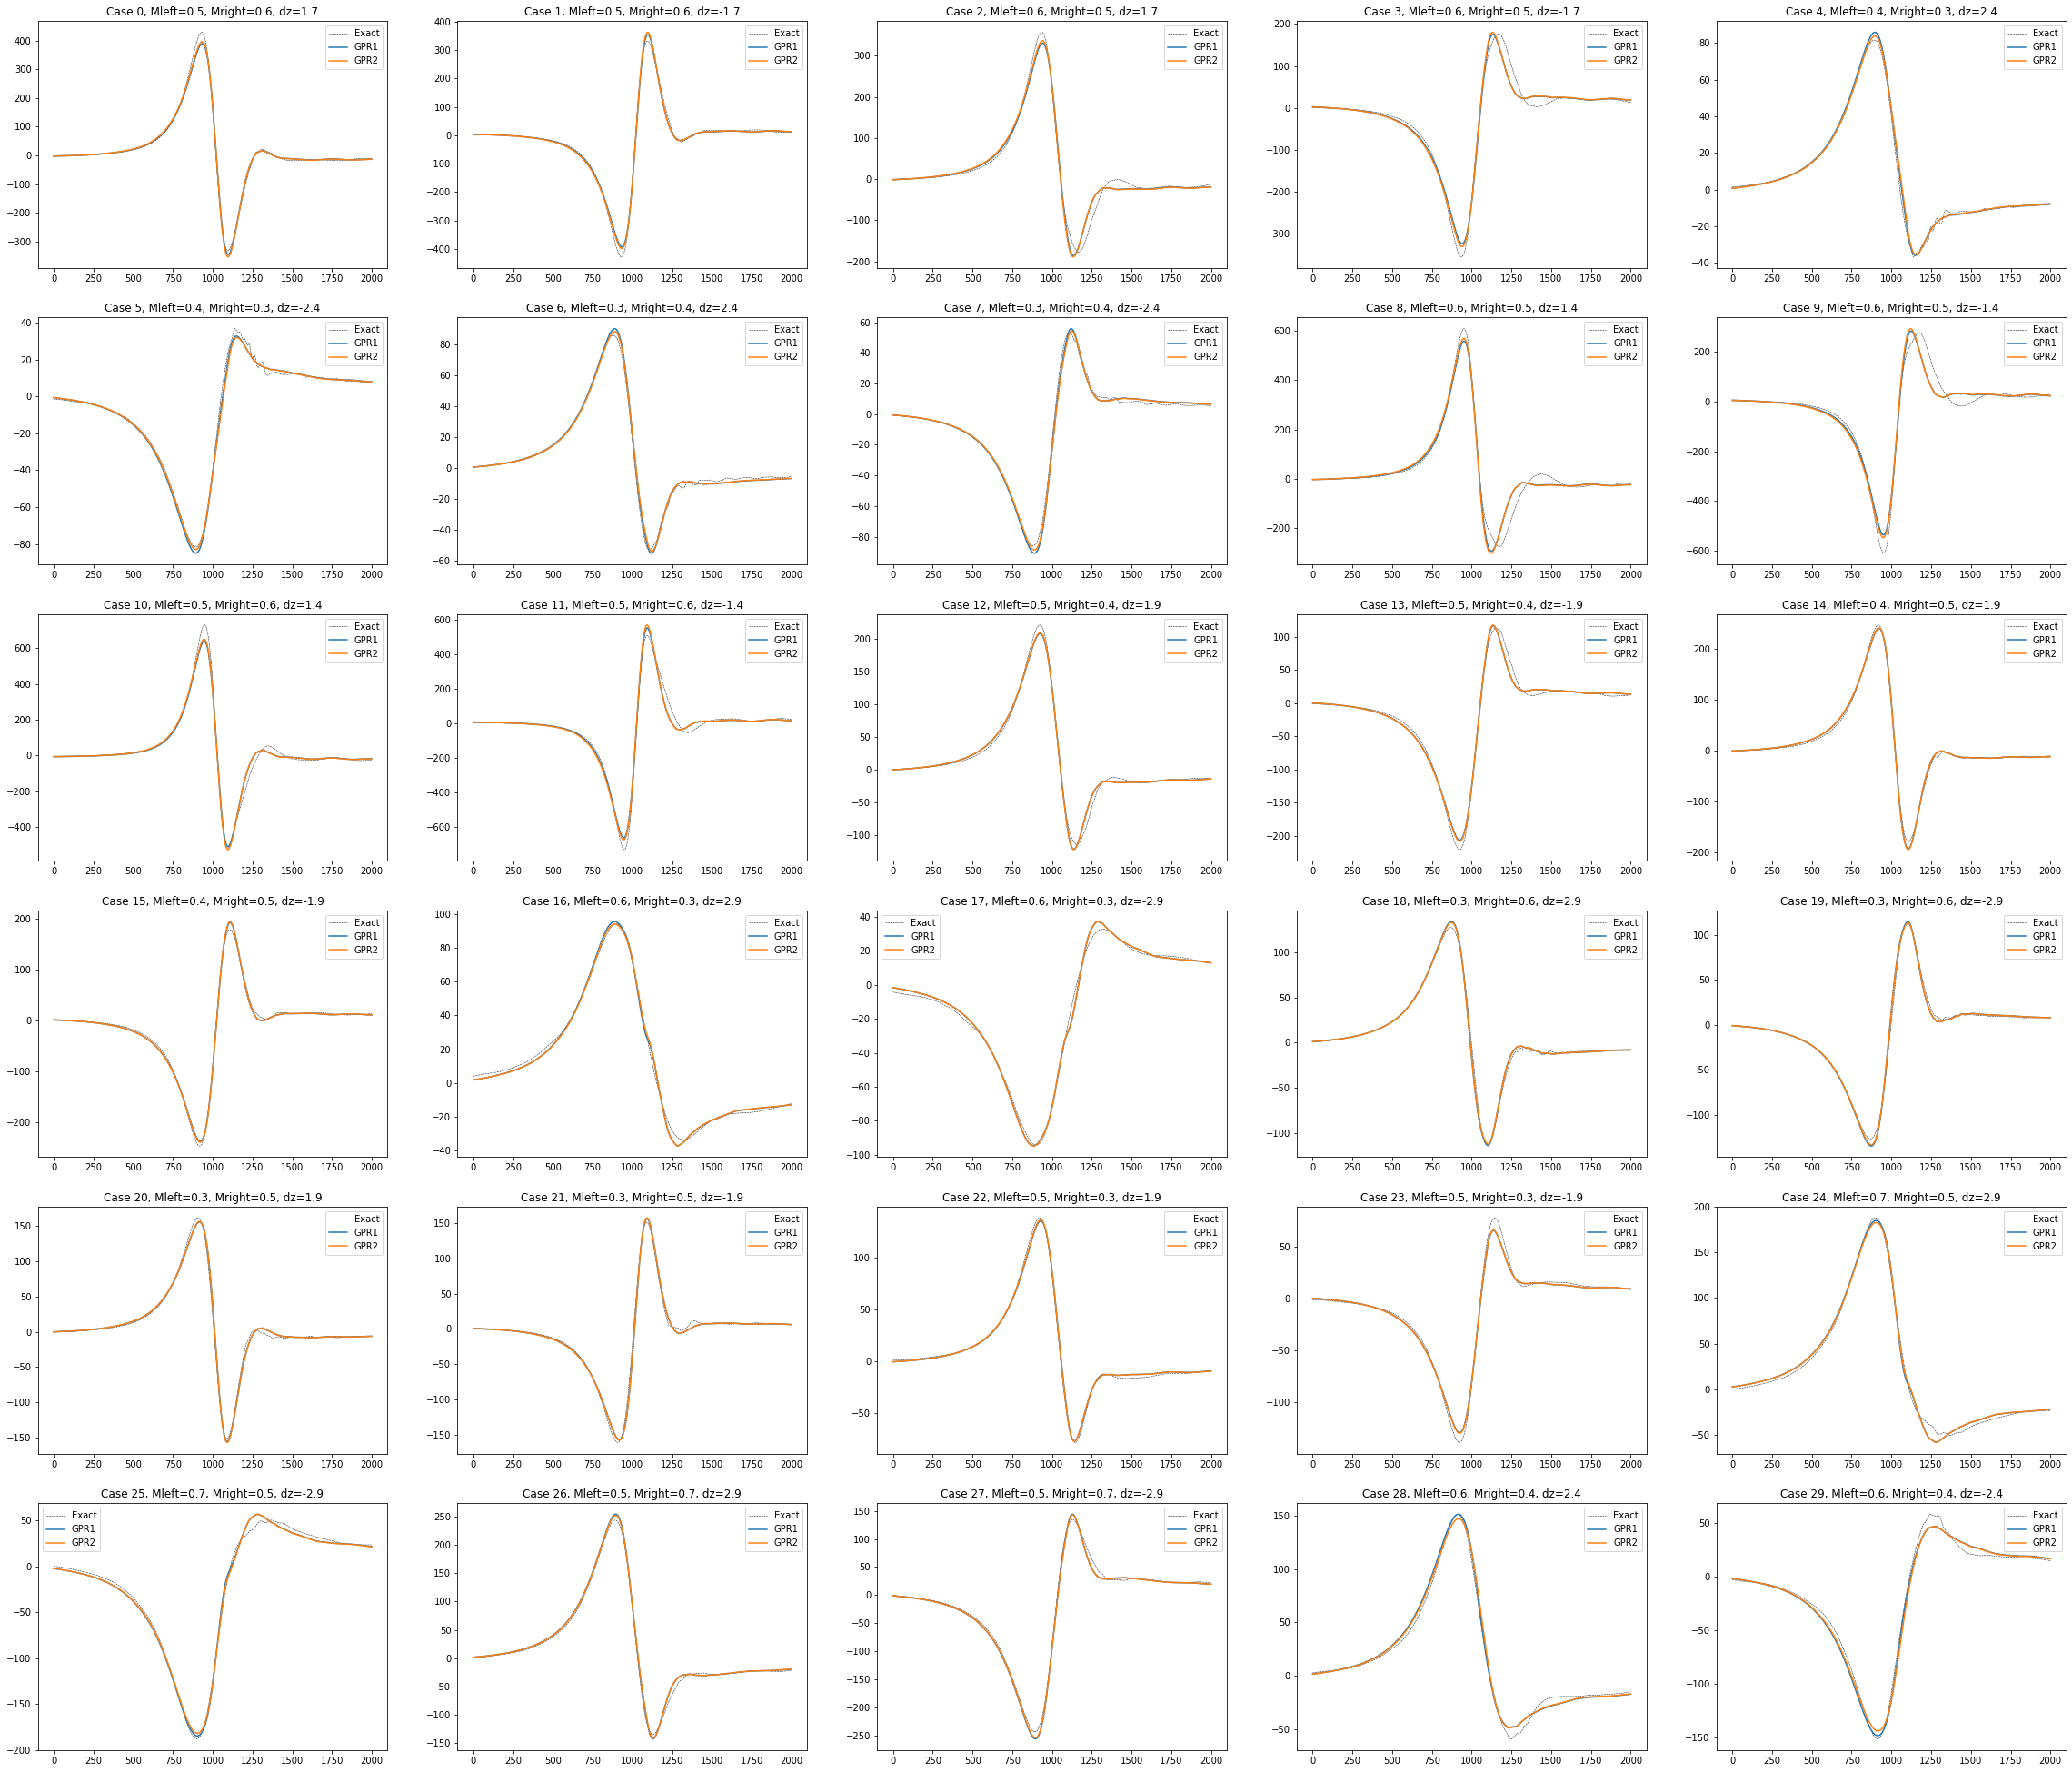

In [132]:
plot_compare(YY,[yyPredictTesting1,yyPredictTesting2],0,30,XX)